In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dropout Basics

In [2]:
prob = 0.5

dropout = nn.Dropout(p=prob)
x = torch.ones(10)

y = dropout(x)

print(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 0., 0., 0., 0., 0., 0., 0., 2., 2.])
tensor(0.6000)


In [3]:
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [4]:
dropout.eval()
y = F.dropout(x)
print(y)

y = F.dropout(x, training=False)
print(y)

tensor([2., 0., 0., 2., 2., 0., 2., 2., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [5]:
dropout.train()
y = dropout(x)
print(y)

tensor([2., 0., 2., 0., 2., 0., 2., 0., 0., 0.])


# Two Armies Classification using Dropout

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

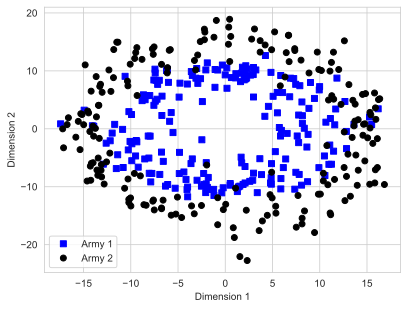

In [7]:
num_clust = 200

theta = np.linspace(0, 4*np.pi, num_clust)
rad_1 = 10
rad_2 = 15

a = [rad_1*np.cos(theta) + np.random.randn(num_clust)*3, rad_1*np.sin(theta) + np.random.randn(num_clust)]
b = [rad_2*np.cos(theta) + np.random.randn(num_clust), rad_2*np.sin(theta) + np.random.randn(num_clust)*3]

labels = np.vstack((np.zeros((num_clust, 1)), np.ones((num_clust, 1))))

data = np.hstack((a, b)).T

data_torch = torch.tensor(data).float()
labels_tensor = torch.tensor(labels).float()

plt.plot(data_torch[np.where(labels == 0)[0], 0], data_torch[np.where(labels == 0)[0], 1], 'bs')
plt.plot(data_torch[np.where(labels == 1)[0], 0], data_torch[np.where(labels == 1)[0], 1], 'ko')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(["Army 1", "Army 2"]);

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(data_torch, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [9]:
class ArmyModel(nn.Module):
    def __init__(self, drop_out_rate):
        super().__init__()
        
        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)
        
        self.drop = drop_out_rate
    
    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        
        x = F.dropout(x, p=self.drop, training=self.training)
        
        x = self.hidden(x)
        x = F.relu(x)
        
        x = F.dropout(x, p=self.drop, training=self.training)
        
        x = self.output(x)
        
        return x

In [10]:
def createModel(drop_out_rate):
    armyModel = ArmyModel(drop_out_rate)
    
    loss_fun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.SGD(armyModel.parameters(), lr=0.002)
    
    return armyModel, loss_fun, optimizer

In [11]:
num_epochs = 500

def trainModel(armyModel, loss_fun, optimizer):
    
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        armyModel.train()
        
        batch_acc = []
        for x, y in train_loader:
            y_hat = armyModel(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_acc.append(100*torch.mean(((y_hat > 0.5) == y).float()).item())
        
        train_acc.append(np.mean(batch_acc))
        
        armyModel.eval()
        x, y = next(iter(test_loader))
        y_hat = armyModel(x)
        test_acc.append(100*torch.mean(((y_hat > 0.5) == y).float()).item())
        
    return train_acc, test_acc

In [12]:
dropout = 0.0
armyModel, loss_fun, optimizer = createModel(dropout)
train_acc, test_acc = trainModel(armyModel, loss_fun, optimizer)

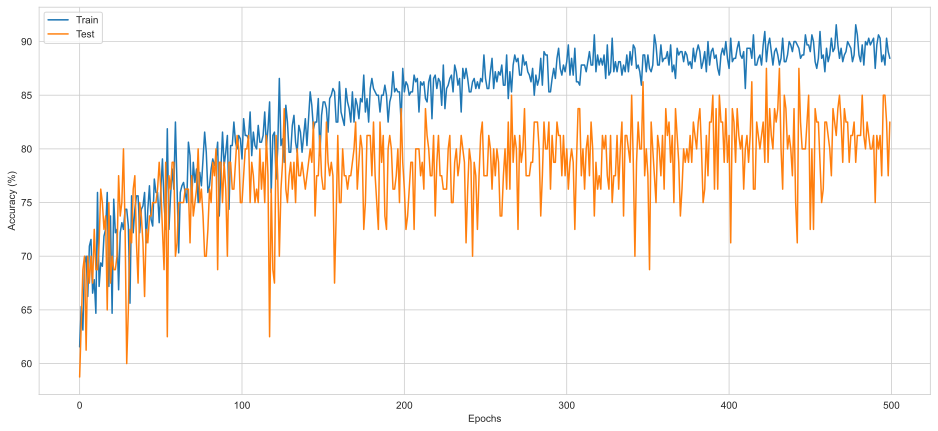

In [13]:
plt.figure(figsize=(16, 7))
plt.plot(train_acc)
plt.plot(test_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"]);

In [14]:
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode="same")

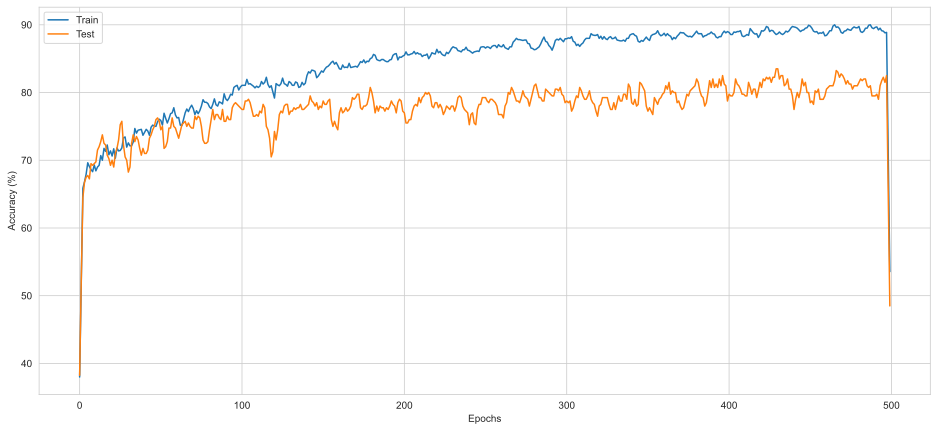

In [15]:
plt.figure(figsize=(16, 7))
plt.plot(smooth(train_acc))
plt.plot(smooth(test_acc))
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"]);

In [16]:
dropoutrates = np.arange(10)/10
results = np.zeros((len(dropoutrates), 2))

for rate in range(len(dropoutrates)):
    armyModel, loss_fun, optimizer = createModel(dropout)
    train_acc, test_acc = trainModel(armyModel, loss_fun, optimizer)
    
    results[rate, 0] = np.mean(train_acc[-100:])
    results[rate, 1] = np.mean(test_acc[-100:])

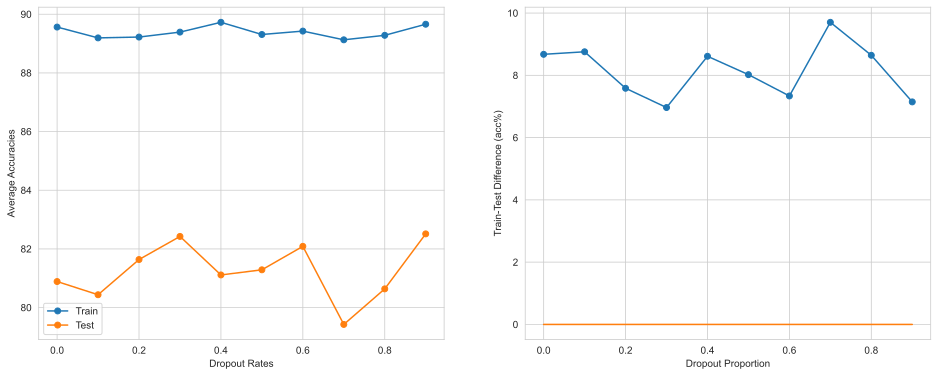

In [17]:
_, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(dropoutrates, results, 'o-')
ax[0].set_xlabel("Dropout Rates")
ax[0].set_ylabel("Average Accuracies")
ax[0].legend(["Train", "Test"])

ax[1].plot(dropoutrates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, 0.9], [0, 0])
ax[1].set_xlabel("Dropout Proportion")
ax[1].set_ylabel("Train-Test Difference (acc%)");

# Iris Data Classification with Dropout

In [18]:
import seaborn as sns

data_iris = sns.load_dataset("iris")

data_tensor = torch.tensor(data_iris[data_iris.columns[:4]].values).float()
labels_tensor = torch.zeros(len(data_iris), dtype=torch.long)
labels_tensor[data_iris.species == "versicolor"] = 1
labels_tensor[data_iris.species == "virginica"] = 2

In [19]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=12, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [20]:
class AnnIris(nn.Module):
    def __init__(self, drop_out):
        super().__init__()
        
        self.input = nn.Linear(4, 12)
        
        self.hidden = nn.Linear(12, 12)
        
        self.output = nn.Linear(12, 3)
        
        self.drop_out = drop_out
    
    def forward(self, x):
        
        x = self.input(x)
        x = F.relu(x)
        
        x = F.dropout(x, p=self.drop_out, training=self.training)
        
        x = self.hidden(x)
        x = F.relu(x)
        
        x = F.dropout(x, p=self.drop_out, training=self.training)
        
        x = self.output(x)
        
        return x

In [21]:
def iris_model(drop_out):
    annIris = AnnIris(drop_out)
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(annIris.parameters(), lr=0.005)
    
    return annIris, loss_fun, optimizer

In [22]:
num_epochs = 500

def trainModel(annIris, loss_fun, optimizer):
    
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        annIris.train()
        
        batch_acc = []
        
        for x, y in train_loader:
            y_hat = annIris(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
        
        train_acc.append(np.mean(batch_acc))

        annIris.eval()
        x, y = next(iter(test_loader))
        test_acc.append(100*torch.mean((torch.argmax(annIris(x), axis=1) == y).float()).item())
    
    return train_acc, test_acc

In [23]:
dropout = 0.0

annIris, loss_fun, optimizer = iris_model(dropout)
train_acc, test_acc = trainModel(annIris, loss_fun, optimizer)

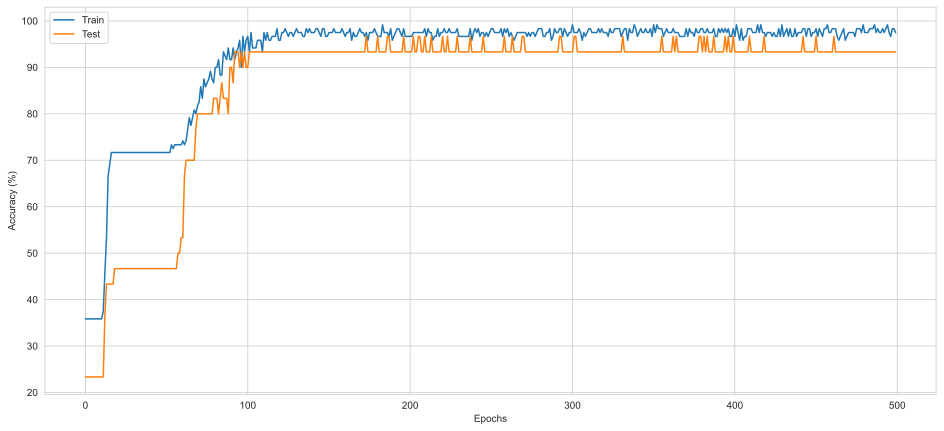

In [24]:
plt.figure(figsize=(16, 7))
plt.plot(train_acc)
plt.plot(test_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"]);

In [25]:
dropout = np.arange(10)/10
results = np.zeros((len(dropout), 2))

for rate in range(len(dropout)):
    annIris, loss_fun, optimizer = iris_model(dropout[rate])
    train_acc, test_acc = trainModel(annIris, loss_fun, optimizer)

    results[rate, 0] = np.mean(train_acc[-50:])
    results[rate, 1] = np.mean(test_acc[-50:])

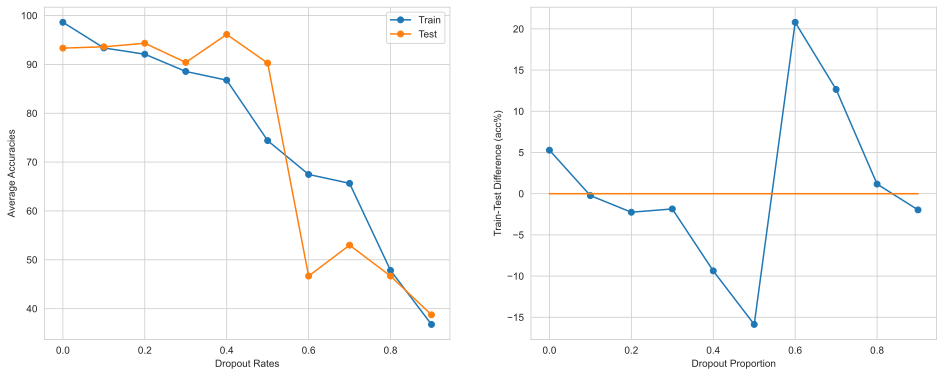

In [26]:
_, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(dropout, results, 'o-')
ax[0].set_xlabel("Dropout Rates")
ax[0].set_ylabel("Average Accuracies")
ax[0].legend(["Train", "Test"])

ax[1].plot(dropout, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, 0.9], [0, 0])
ax[1].set_xlabel("Dropout Proportion")
ax[1].set_ylabel("Train-Test Difference (acc%)");

# L2

In [27]:
data_iris = sns.load_dataset("iris")

data_tensor = torch.tensor(data_iris[data_iris.columns[:4]].values).float()
labels_tensor = torch.zeros(len(data_iris), dtype=torch.long)
labels_tensor[data_iris.species == "versicolor"] = 1
labels_tensor[data_iris.species == "virginica"] = 2

In [28]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=12, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [29]:
def createAnnModel(lambda_l2):
    annIris = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 3))
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(annIris.parameters(), lr=0.005, weight_decay=lambda_l2)
    
    return annIris, loss_fun, optimizer

In [30]:
num_epochs = 400

def trainModel(annIris, loss_fun, optimizer):
    
    train_acc = []
    test_acc = []
    losses = []
    
    for epoch in range(num_epochs):
        
        batch_acc = []
        batch_loss = []
        
        for x, y in train_loader:
            y_hat = annIris(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
            batch_loss.append(loss.item())
        
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))
        
        x, y = next(iter(test_loader))
        test_acc.append(100*torch.mean((torch.argmax(annIris(x), axis=1) == y).float()).item())
    
    return train_acc, test_acc, losses

In [31]:
lambda_l2 = 0.01

annIris, loss_fun, optimizer = createAnnModel(lambda_l2)
train_acc, test_acc, losses = trainModel(annIris, loss_fun, optimizer)

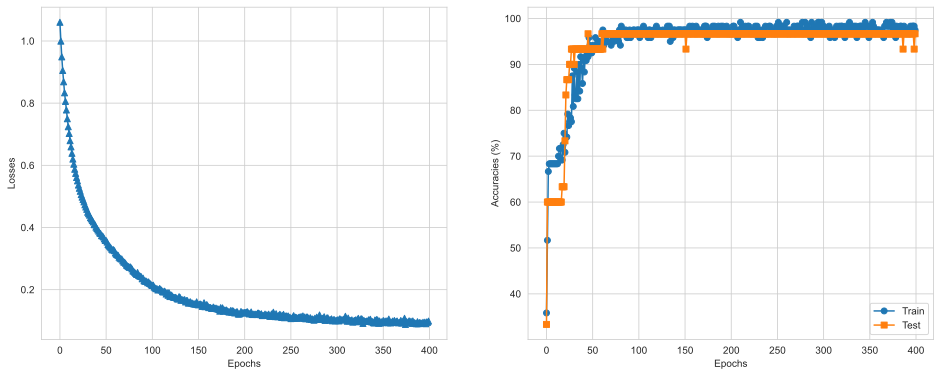

In [32]:
_, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(losses, "^-")
ax[0].set_ylabel("Losses")
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, 'o-')
ax[1].plot(test_acc, 's-')
ax[1].set_ylabel("Accuracies (%)")
ax[1].set_xlabel("Epochs")
ax[1].legend(["Train", "Test"]);

In [33]:
def smooth(x, k):
    return np.convolve(x, np.ones(k)/k, mode="same")

In [34]:
lambda_l2 = np.linspace(0, 0.1, 10)

acc_res_train = np.zeros((num_epochs, len(lambda_l2)))
acc_res_test = np.zeros((num_epochs, len(lambda_l2)))

for l2 in range(len(lambda_l2)):
    annIris, loss_fun, optimizer = createAnnModel(lambda_l2[l2])
    train_acc, test_acc, losses = trainModel(annIris, loss_fun, optimizer)
    
    acc_res_train[:, l2] = smooth(train_acc, 10)
    acc_res_test[:, l2] = smooth(test_acc, 10)

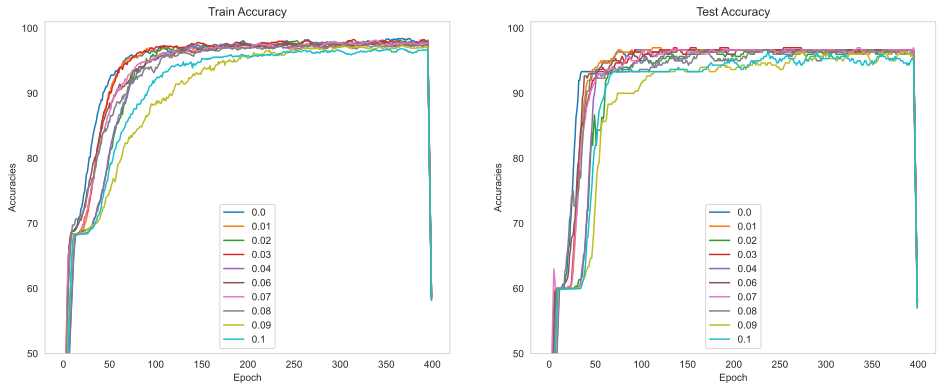

In [35]:
_, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(acc_res_train)
ax[0].set_title("Train Accuracy")

ax[1].plot(acc_res_test)
ax[1].set_title("Test Accuracy")

leg_labels = [np.round(i, 2) for i in lambda_l2]

for i in range(2):
    ax[i].legend(leg_labels)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracies")
    ax[i].set_ylim([50, 101])
    ax[i].grid()
plt.show()

# L1 Manually

In [36]:
def createAnnModel():
    annIris = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 3))

    loss_fun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(annIris.parameters(), lr=0.005)

    return annIris, loss_fun, optimizer

In [37]:
num_epochs = 400

def trainModel(annIris, loss_fun, optimizer, lambda_l1):

    train_acc = []
    test_acc = []
    losses = []
    
    new_weights = 0
    for param_name, weight in annIris.named_parameters():
        if "bias" not in param_name:
            new_weights += weight.numel()
    
    for epoch in range(num_epochs):

        batch_acc = []
        batch_loss = []

        for x, y in train_loader:
            y_hat = annIris(x)

            loss = loss_fun(y_hat, y)
            
            l1_term = torch.tensor(0., requires_grad=True)

            for param_name, weight in annIris.named_parameters():
                if "bias" not in param_name:
                    l1_term = l1_term + torch.sum(torch.abs(weight))
            
            loss += lambda_l1*l1_term/new_weights

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
            batch_loss.append(loss.item())

        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))

        x, y = next(iter(test_loader))
        test_acc.append(100*torch.mean((torch.argmax(annIris(x), axis=1) == y).float()).item())

    return train_acc, test_acc, losses

In [38]:
lambda_l1 = 0.001

annIris, loss_fun, optimizer = createAnnModel()
train_acc, test_acc, losses = trainModel(annIris, loss_fun, optimizer, lambda_l1)

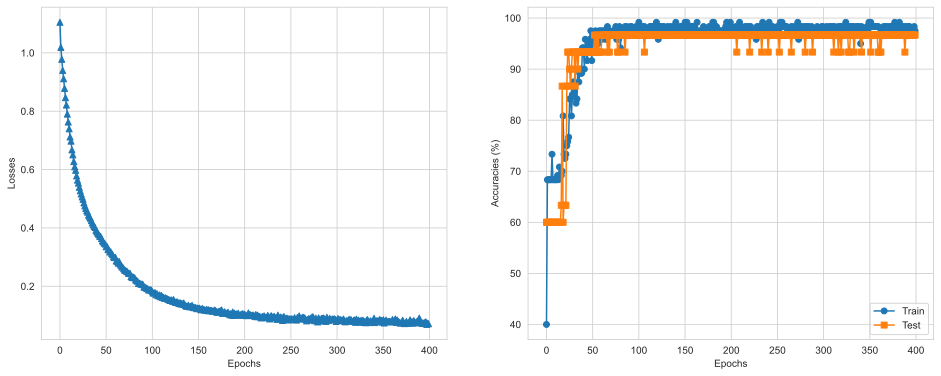

In [39]:
_, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(losses, "^-")
ax[0].set_ylabel("Losses")
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, 'o-')
ax[1].plot(test_acc, 's-')
ax[1].set_ylabel("Accuracies (%)")
ax[1].set_xlabel("Epochs")
ax[1].legend(["Train", "Test"]);

In [40]:
def smooth(x, k):
    return np.convolve(x, np.ones(k)/k, mode="same")

In [41]:
lambda_l1 = np.linspace(0, 0.005, 10)

acc_res_train = np.zeros((num_epochs, len(lambda_l1)))
acc_res_test = np.zeros((num_epochs, len(lambda_l1)))

for l1 in range(len(lambda_l1)):
    annIris, loss_fun, optimizer = createAnnModel()
    train_acc, test_acc, losses = trainModel(annIris, loss_fun, optimizer, lambda_l1[l1])

    acc_res_train[:, l1] = smooth(train_acc, 10)
    acc_res_test[:, l1] = smooth(test_acc, 10)

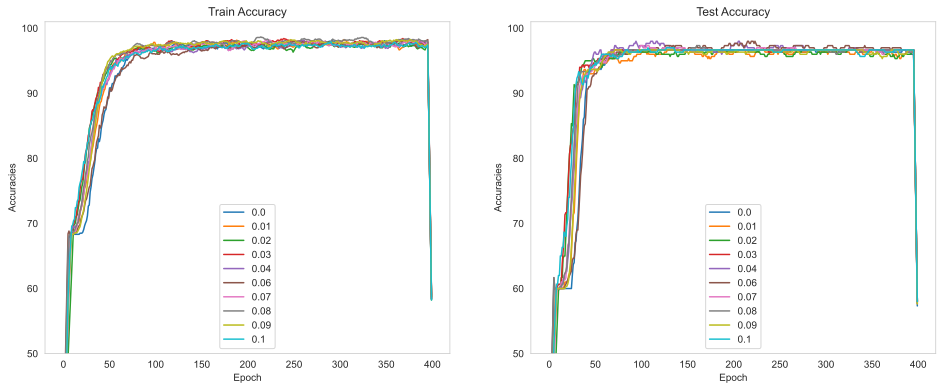

In [42]:
_, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(acc_res_train)
ax[0].set_title("Train Accuracy")

ax[1].plot(acc_res_test)
ax[1].set_title("Test Accuracy")

leg_labels = [np.round(i, 2) for i in lambda_l2]

for i in range(2):
    ax[i].legend(leg_labels)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracies")
    ax[i].set_ylim([50, 101])
    ax[i].grid()
plt.show()

# Mini-Batches

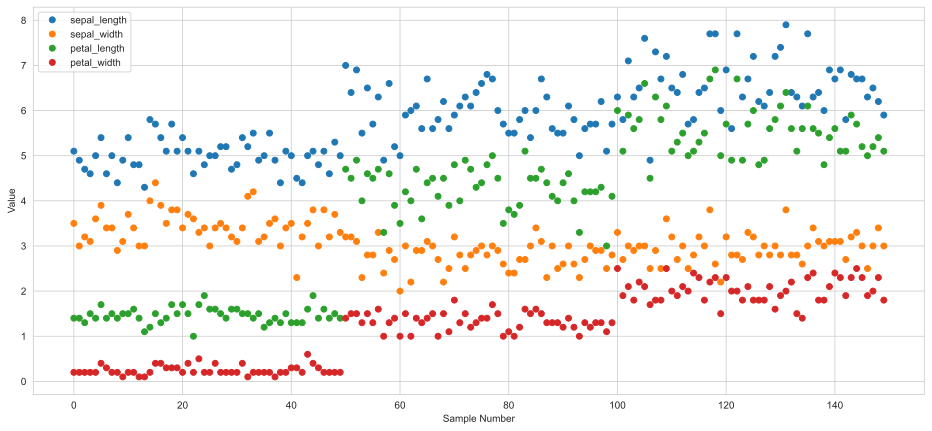

In [43]:
data_iris.plot(marker='o', linestyle='none', figsize=(16, 7))
plt.xlabel("Sample Number")
plt.ylabel("Value");

In [44]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [45]:
for x, y in train_loader:
    print(x.shape)

torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([16, 4])


In [46]:
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [47]:
for x, y in train_loader:
    print(x.shape)

torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([16, 4])
torch.Size([8, 4])


# L2 Manually

In [48]:
def createAnnModel():
    annIris = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 3))

    loss_fun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(annIris.parameters(), lr=0.005)

    return annIris, loss_fun, optimizer

In [49]:
num_epochs = 400

def trainModel(annIris, loss_fun, optimizer, lambda_l2):

    train_acc = []
    test_acc = []
    losses = []

    new_weights = 0
    for param_name, weight in annIris.named_parameters():
        if "bias" not in param_name:
            new_weights += weight.numel()

    for epoch in range(num_epochs):

        batch_acc = []
        batch_loss = []

        for x, y in train_loader:
            y_hat = annIris(x)

            loss = loss_fun(y_hat, y)

            l2_term = torch.tensor(0., requires_grad=True)

            for param_name, weight in annIris.named_parameters():
                if "bias" not in param_name:
                    l2_term = l2_term + torch.sum(torch.square(weight))

            loss += lambda_l2*l2_term/new_weights

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
            batch_loss.append(loss.item())

        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))

        x, y = next(iter(test_loader))
        test_acc.append(100*torch.mean((torch.argmax(annIris(x), axis=1) == y).float()).item())

    return train_acc, test_acc, losses

In [50]:
lambda_l2 = 0.01

annIris, loss_fun, optimizer = createAnnModel()
train_acc, test_acc, losses = trainModel(annIris, loss_fun, optimizer, lambda_l2)

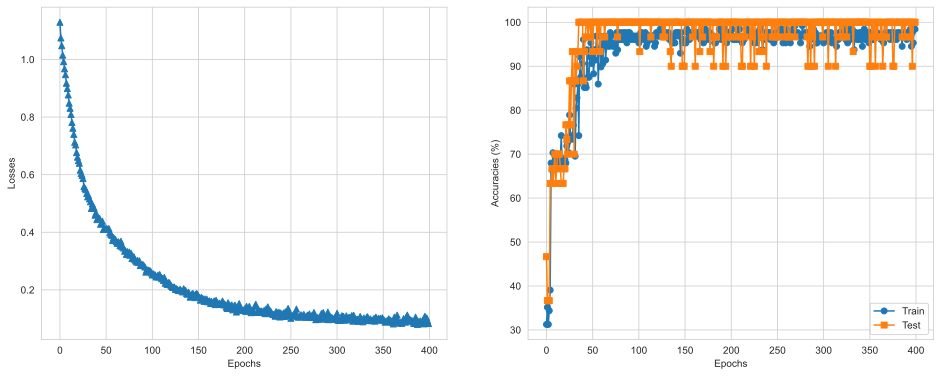

In [51]:
_, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(losses, "^-")
ax[0].set_ylabel("Losses")
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, 'o-')
ax[1].plot(test_acc, 's-')
ax[1].set_ylabel("Accuracies (%)")
ax[1].set_xlabel("Epochs")
ax[1].legend(["Train", "Test"]);

In [52]:
def smooth(x, k):
    return np.convolve(x, np.ones(k)/k, mode="same")

In [53]:
lambda_l2 = np.linspace(0, 0.1, 10)

acc_res_train = np.zeros((num_epochs, len(lambda_l2)))
acc_res_test = np.zeros((num_epochs, len(lambda_l2)))

for l2 in range(len(lambda_l2)):
    annIris, loss_fun, optimizer = createAnnModel()
    train_acc, test_acc, losses = trainModel(annIris, loss_fun, optimizer, lambda_l2[l2])

    acc_res_train[:, l2] = smooth(train_acc, 10)
    acc_res_test[:, l2] = smooth(test_acc, 10)

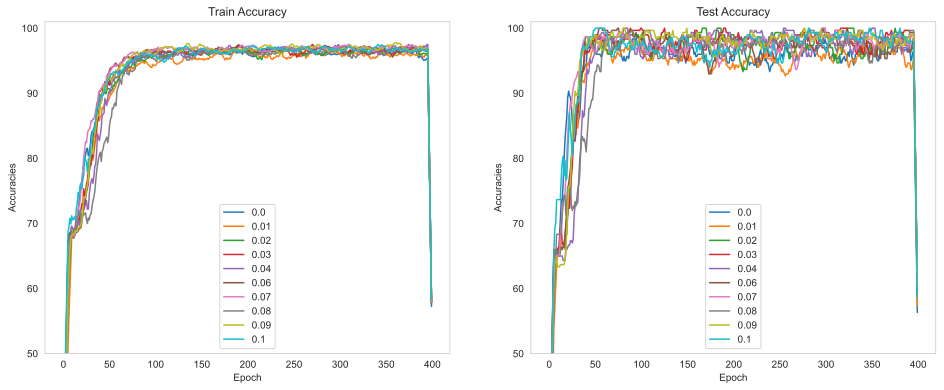

In [54]:
_, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(acc_res_train)
ax[0].set_title("Train Accuracy")

ax[1].plot(acc_res_test)
ax[1].set_title("Test Accuracy")

leg_labels = [np.round(i, 2) for i in lambda_l2]

for i in range(2):
    ax[i].legend(leg_labels)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracies")
    ax[i].set_ylim([50, 101])
    ax[i].grid()
plt.show()